# Imports

In [ ]:
!pip install pandas opencv-python numpy matplotlib scikit-learn torch torchvision albumentations pillow imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import os
import cv2
import torch
import imagehash
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights

# Data preprocessing

In [ ]:
path = '/content/drive/MyDrive/dataS21/Task-Mate-Kenyan-Sign-Language-Classification-Challenge/'
train_csv_path = path + 'Train.csv'
image_dir = path + 'Images'

df = pd.read_csv(train_csv_path)
print("First lines of train.csv:")
print(df.head())
print()
print("Class distribution:")
print(df['Label'].value_counts())
print()
print("Checking the first 10 images:")
for img_path in df['img_IDS'][:10]:
    full_img_path = os.path.join(image_dir, img_path + '.jpg')
    img = cv2.imread(full_img_path)
    if img is None:
        print(f"Loading error: {full_img_path}")
    else:
        print(f"Image {img_path}: size {img.shape}")

First lines of train.csv:
            img_IDS             Label
0  ImageID_33HMDMJ3            Temple
1  ImageID_V5POEX4O            Church
2  ImageID_89CCCCW6  Enough/Satisfied
3  ImageID_GNJXOWX5                Me
4  ImageID_7Q9LOP7R              Love

Class distribution:
Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

Checking the first 10 images:
Image ImageID_33HMDMJ3: size (1280, 720, 3)
Image ImageID_V5POEX4O: size (1280, 720, 3)
Image ImageID_89CCCCW6: size (720, 1280, 3)
Image ImageID_GNJXOWX5: size (1280, 720, 3)
Image ImageID_7Q9LOP7R: size (1280, 720, 3)
Image ImageID_0TEORZRD: size (1280, 720, 3)
Image ImageID_8UNM9NYX: size (720, 1280, 3)
Image ImageID_98WYAZT3: size (1280, 720, 3)
Image ImageID_P8COO08B: size (720, 1280, 3)
Image ImageID_3EC735S1: size (1280, 720, 3)


In [ ]:
def compute_hash(img_path):
    try:
        full_img_path = os.path.join(image_dir, img_path + '.jpg')
        img = Image.open(full_img_path)
        img = img.resize((256, 256), Image.Resampling.LANCZOS)
        return str(imagehash.average_hash(img))
    except:
        return None

def compute_hashes_parallel(img_paths):
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        hashes = list(tqdm(executor.map(compute_hash, img_paths), total=len(img_paths), desc="Computing hashes"))
    return hashes

In [ ]:
img_paths = df['img_IDS'].tolist()
df['hash'] = compute_hashes_parallel(img_paths)

duplicates = df[df['hash'].duplicated(keep=False)]
print()
print(f"Found {len(duplicates)} dups")

df_clean = df.drop_duplicates(subset='hash', keep='first')
df_clean = df_clean.drop(columns=['hash'])
print(f"After removing dups: {len(df_clean)}")

df_clean.to_csv(path + 'train_clean.csv', index=False)

Computing hashes: 100%|██████████| 6249/6249 [13:22<00:00,  7.78it/s]


Found 2 dups
After removing dups: 6248


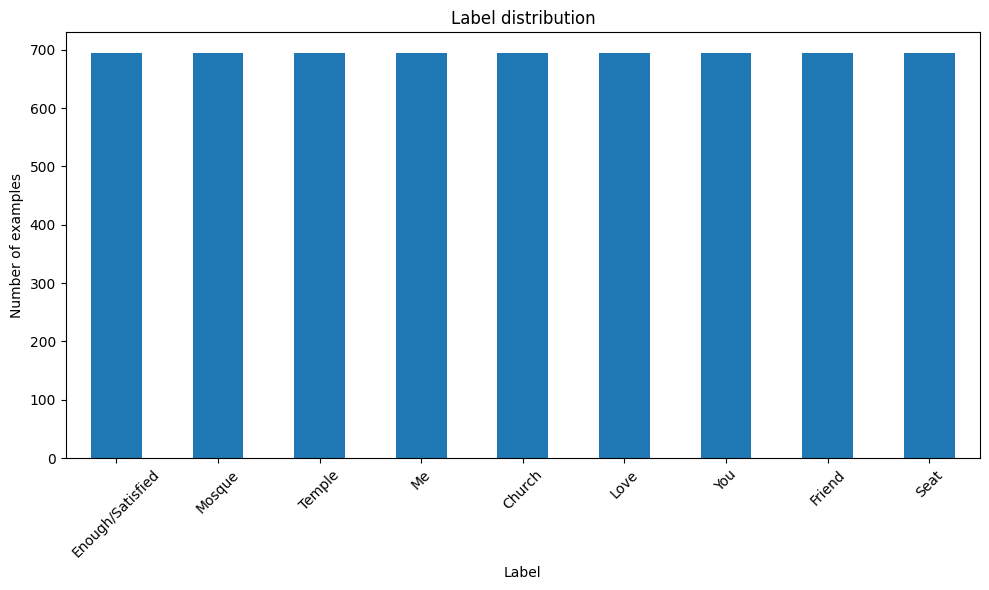

In [ ]:
plt.figure(figsize=(10, 6))
df_clean['Label'].value_counts().plot(kind='bar')
plt.title('Label distribution')
plt.xlabel('Label')
plt.ylabel('Number of examples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(
    df_clean,
    test_size=0.33,
    stratify=df_clean['Label'],
    random_state=42
)

train_df.to_csv(path + 'train_split.csv', index=False)
val_df.to_csv(path + 'val_split.csv', index=False)

print("\nTraining set:", len(train_df), "examples")
print("Distribution of classes in the training set:")
print(train_df['Label'].value_counts(normalize=True))
print("\nValidation set:", len(val_df), "examples")
print("Distribution of classes in the validation set:")
print(val_df['Label'].value_counts(normalize=True))


Training set: 4186 examples
Distribution of classes in the training set:
Label
Mosque              0.111323
You                 0.111085
Love                0.111085
Enough/Satisfied    0.111085
Church              0.111085
Friend              0.111085
Temple              0.111085
Seat                0.111085
Me                  0.111085
Name: proportion, dtype: float64

Validation set: 2062 examples
Distribution of classes in the validation set:
Label
Enough/Satisfied    0.111542
Seat                0.111057
Temple              0.111057
Friend              0.111057
Mosque              0.111057
You                 0.111057
Church              0.111057
Love                0.111057
Me                  0.111057
Name: proportion, dtype: float64


# Base augmentation

In [ ]:
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussianBlur(p=0.2),
    A.GaussNoise(p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset, DataLoader

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['Label'].unique()))}
        self.df['Label_idx'] = self.df['Label'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_IDS']
        full_img_path = os.path.join(self.image_dir, img_path + '.jpg')
        img = cv2.imread(full_img_path)
        if img is None:
            raise FileNotFoundError(f"Failed to load image: {full_img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = self.df.iloc[idx]['Label_idx']

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [ ]:
batch_size = 32

train_dataset = GestureDataset(path + 'train_split.csv', image_dir, transform=train_transform)
val_dataset = GestureDataset(path + 'val_split.csv', image_dir, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

num_classes = len(df['Label'].unique())
print(f"Number of labels: {num_classes}")

Number of labels: 9


In [ ]:
model = LeNet(num_classes=num_classes)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Function for calculating ROC AUC (one-vs-rest)

In [ ]:
def compute_roc_auc(y_true, y_pred_proba, num_classes):
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    auc_scores = []
    for i in range(num_classes):
        try:
            auc = roc_auc_score(y_true == i, y_pred_proba[:, i])
            auc_scores.append(auc)
        except ValueError:
            continue
    return np.mean(auc_scores) if auc_scores else 0.0

# Result of LeNet

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, num_classes, model_name='model'):
    results_df = pd.DataFrame(columns=[
        'Epoch', 'Train Loss', 'Train Accuracy', 'Train ROC AUC',
        'Val Loss', 'Val Accuracy', 'Val ROC AUC'
    ])
    best_auc = 0.0
    best_model_path = f'best_{model_name}.pth'

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_loss = train_loss / len(train_loader)
        train_auc = compute_roc_auc(train_labels, train_preds, num_classes)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = val_correct / val_total
        val_loss = val_loss / len(val_loader)
        val_auc = compute_roc_auc(val_labels, val_preds, num_classes)

        epoch_results = pd.DataFrame([{
            'Epoch': epoch + 1,
            'Train Loss': f"{train_loss:.4f}",
            'Train Accuracy': f"{train_accuracy:.4f}",
            'Train ROC AUC': f"{train_auc:.4f}",
            'Val Loss': f"{val_loss:.4f}",
            'Val Accuracy': f"{val_accuracy:.4f}",
            'Val ROC AUC': f"{val_auc:.4f}"
        }])
        results_df = pd.concat([results_df, epoch_results], ignore_index=True)

    return results_df, best_auc

In [ ]:
results_df, best_auc = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device,
    num_classes=num_classes,
    model_name='lenet'
)

results_df

Epoch 20/20 - Validation: 100%|██████████| 65/65 [00:41<00:00,  1.57it/s]


,Epoch,Train Loss,Train Accuracy,Train ROC AUC,Val Loss,Val Accuracy,Val ROC AUC
0,1,2.2098,0.1104,0.4966,2.1957,0.1198,0.5313
1,2,2.1989,0.1156,0.5049,2.1941,0.1392,0.5594
2,3,2.1968,0.1092,0.5136,2.1922,0.1465,0.5672
3,4,2.1953,0.1266,0.5221,2.1907,0.1440,0.5778
4,5,2.1934,0.1249,0.5283,2.1872,0.1440,0.5709
5,6,2.1897,0.1276,0.5357,2.1781,0.1571,0.5725
6,7,2.1853,0.1292,0.5455,2.1742,0.1469,0.5824
7,8,2.1783,0.1455,0.5582,2.1646,0.1600,0.5920
8,9,2.1718,0.1505,0.5612,2.1504,0.1654,0.5945
9,10,2.1688,0.1517,0.5685,2.1498,0.1717,0.6050


# ResNet18

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Different augmentation

In [16]:
enhanced_transform = A.Compose([
    A.Affine(translate_percent=0.1, scale=(0.85, 1.15), rotate=(-45, 45), p=0.5),
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), p=0.5),
    A.CLAHE(clip_limit=4.0, p=0.3),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussianBlur(p=0.2),
    A.GaussNoise(p=0.2),
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_enh = GestureDataset(path + 'train_split.csv', image_dir, transform=enhanced_transform)
train_loader_enh = DataLoader(
    train_dataset_enh,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# MixUp, CutMix

In [17]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Results of ResNet18

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
results_df = pd.DataFrame(columns=['Augmentation', 'Epoch', 'Train Loss', 'Train AUC', 'Val AUC'])

def train_and_evaluate(train_loader, val_loader, aug_name, use_mixup=False, use_cutmix=False, use_tta=False, num_epochs=4):
    global results_df
    model.train()
    best_auc = 0.0
    best_model_path = path + f'best_model_{aug_name.lower().replace(" ", "_")}.pth'

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"{aug_name} Epoch {epoch+1}/{num_epochs} - Train"):
            images, labels = images.to(device), labels.to(device)

            if use_mixup:
                images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.2)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            elif use_cutmix:
                images, y_a, y_b, lam = cutmix_data(images, labels)
                outputs = model(images)
                loss = cutmix_criterion(criterion, outputs, y_a, y_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(F.softmax(outputs, dim=1).detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_auc = compute_roc_auc(train_labels, train_preds, num_classes)

        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"{aug_name} Epoch {epoch+1}/{num_epochs} - Val"):
                images, labels = images.to(device), labels.to(device)

                if use_tta:
                    outputs_orig = model(images)
                    probs_orig = F.softmax(outputs_orig, dim=1)
                    images_flipped = torch.flip(images, dims=[3])
                    outputs_flipped = model(images_flipped)
                    probs_flipped = F.softmax(outputs_flipped, dim=1)
                    probs = (probs_orig + probs_flipped) / 2
                else:
                    outputs = model(images)
                    probs = F.softmax(outputs, dim=1)

                val_preds.extend(probs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_auc = compute_roc_auc(val_labels, val_preds, num_classes)

        epoch_results = pd.DataFrame([{
            'Augmentation': aug_name + ('_TTA' if use_tta else ''),
            'Epoch': epoch + 1,
            'Train Loss': f"{train_loss:.4f}",
            'Train AUC': f"{train_auc:.4f}",
            'Val AUC': f"{val_auc:.4f}"
        }])
        results_df = pd.concat([results_df, epoch_results], ignore_index=True)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), best_model_path)

    return best_auc

In [21]:
auc_base = train_and_evaluate(train_loader, val_loader, "Base Aug")

Base Aug Epoch 4/4 - Val: 100%|██████████| 65/65 [03:03<00:00,  2.82s/it]


In [22]:
auc_enh = train_and_evaluate(train_loader_enh, val_loader, "Enhanced Aug")

Enhanced Aug Epoch 4/4 - Val: 100%|██████████| 65/65 [02:58<00:00,  2.75s/it]


In [23]:
auc_mixup = train_and_evaluate(train_loader, val_loader, "MixUp", use_mixup=True)

MixUp Epoch 4/4 - Val: 100%|██████████| 65/65 [03:13<00:00,  2.98s/it]


In [24]:
auc_cutmix = train_and_evaluate(train_loader, val_loader, "CutMix", use_cutmix=True)

CutMix Epoch 4/4 - Val: 100%|██████████| 65/65 [03:02<00:00,  2.81s/it]


In [25]:
results_df

,Augmentation,Epoch,Train Loss,Train AUC,Val AUC
0,Base Aug,1,1.3604,0.8770,0.9737
1,Base Aug,2,0.9428,0.9402,0.9801
2,Base Aug,3,0.7552,0.9617,0.9826
3,Base Aug,4,0.6388,0.9725,0.9859
4,Enhanced Aug,1,0.6964,0.9681,0.9874
5,Enhanced Aug,2,0.7167,0.9654,0.9857
6,Enhanced Aug,3,0.6745,0.9696,0.9859
7,Enhanced Aug,4,0.6203,0.9742,0.9831
8,MixUp,1,0.9330,0.7395,0.9890
9,MixUp,2,0.8237,0.7014,0.9879


# Results of ResNet18 with TTA

In [33]:
auc_base_tta = train_and_evaluate(train_loader, val_loader, "Base Aug", use_tta=True)

Base Aug Epoch 4/4 - Val: 100%|██████████| 65/65 [05:54<00:00,  5.45s/it]


In [34]:
results_df

,Augmentation,Epoch,Train Loss,Train AUC,Val AUC
0,Base Aug,1,1.3604,0.8770,0.9737
1,Base Aug,2,0.9428,0.9402,0.9801
2,Base Aug,3,0.7552,0.9617,0.9826
3,Base Aug,4,0.6388,0.9725,0.9859
4,Enhanced Aug,1,0.6964,0.9681,0.9874
5,Enhanced Aug,2,0.7167,0.9654,0.9857
6,Enhanced Aug,3,0.6745,0.9696,0.9859
7,Enhanced Aug,4,0.6203,0.9742,0.9831
8,MixUp,1,0.9330,0.7395,0.9890
9,MixUp,2,0.8237,0.7014,0.9879


# Test

In [35]:
class TestGestureDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['img_IDS']
        full_img_path = os.path.join(self.image_dir, img_path + '.jpg')
        img = cv2.imread(full_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)

        if 'Label' in self.df.columns:
            label = self.df.iloc[idx]['Label']
            return img, label
        return img

In [36]:
test_csv_path = path + 'Test.csv'
test_dataset = TestGestureDataset(test_csv_path, image_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [44]:
def test_model(model, test_loader, device, num_classes, model_path, use_tta=False, has_labels=False):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_preds = []
    test_labels = []

    label_map = {
        0: 'Church',
        1: 'Enough/Satisfied',
        2: 'Friend',
        3: 'Love',
        4: 'Me',
        5: 'Mosque',
        6: 'Seat',
        7: 'Temple',
        8: 'You'
    }

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            if has_labels:
                images, labels = batch
                labels = labels.to(device)
                test_labels.extend(labels.cpu().numpy())
            else:
                images = batch
            images = images.to(device)

            if use_tta:
                outputs_orig = model(images)
                probs_orig = F.softmax(outputs_orig, dim=1)
                images_flipped = torch.flip(images, dims=[3])
                outputs_flipped = model(images_flipped)
                probs_flipped = F.softmax(outputs_flipped, dim=1)
                probs = (probs_orig + probs_flipped) / 2
            else:
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)

            test_preds.extend(probs.detach().cpu().numpy())

    test_preds = np.array(test_preds)
    test_csv_path = '/content/drive/MyDrive/dataS21/Task-Mate-Kenyan-Sign-Language-Classification-Challenge/Test.csv'
    img_ids = pd.read_csv(test_csv_path)['img_IDS']

    predictions_df = pd.DataFrame({
        'img_IDS': img_ids,
        **{label_map[i]: test_preds[:, i] for i in range(num_classes)}
    })

    output_file = path + 'predictions.csv'
    predictions_df.to_csv(output_file, index=False)

    test_auc = None
    if has_labels:
        test_auc = compute_roc_auc(test_labels, test_preds, num_classes)

    return test_auc, predictions_df

In [45]:
model_path = path + 'best_model_base_aug.pth'
test_auc, predictions_df = test_model(model, test_loader, device, num_classes, model_path, use_tta=False, has_labels=False)

Testing: 100%|██████████| 84/84 [04:05<00:00,  2.92s/it]


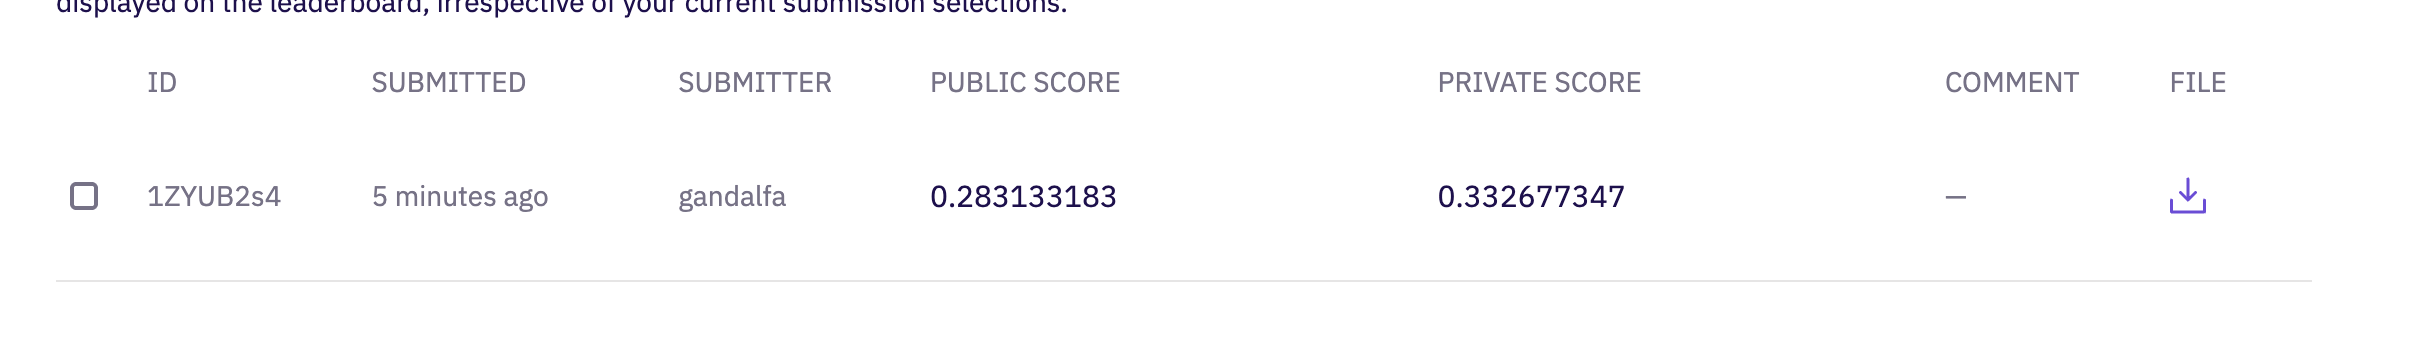